In [1]:
%reset -sf
import numpy as np
import matplotlib.pyplot as plt
import linecache
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle

In [2]:
# initialize mode params
num_mode=3
ny=161
nz=23
y=np.zeros((ny,1))
z=np.zeros((nz,1))
data1=np.zeros((ny,nz))
data2=np.zeros((ny,nz))
mode_data=[['' for i in range(3)] for j in range(1)]

In [3]:
# get mode1-3 E and H data
j=0
for i in range(3+1,3+1+ny):
    y[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

j=0
for i in range(3+ny+2+1,3+ny+2+1+nz):
    z[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

for k in range(num_mode):
    j=0
    for i in range(3+ny+2+nz+2+1,3+ny+2+nz+2+1+ny):
        data1[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode'+str(k+1)+'_ey.txt', i).split()
        j+=1  
    mode_data[0][k]=np.copy(data1.T)

# Normlize integral{|E|^2*dydz} to 1
dy=(y[-1,0]-y[0,0])/(y.shape[0]-1)
dz=(z[-1,0]-z[0,0])/(z.shape[0]-1)
norm_mode=np.zeros((1,num_mode))
for i in range(num_mode):
    norm_mode[0,i]=np.sum(mode_data[0][i]**2*dy*dz)
    mode_data[0][i]/=np.sqrt(norm_mode[0,i])

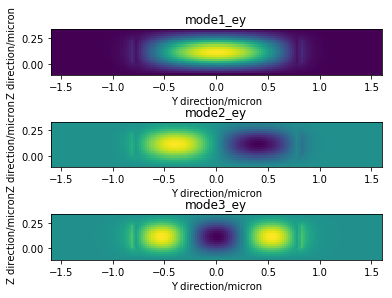

In [4]:
# show three Ey modes
# generate 2d grids for y and z
yy,zz=np.meshgrid(y,z)
plt.figure()
for i in range(num_mode):
    plt.subplot(num_mode, 1, i+1)
    plt.title('mode{}_ey'.format(i+1))
    plt.pcolormesh(yy,zz,mode_data[0][i])
    plt.xlabel("Y direction/micron")
    plt.ylabel("Z direction/micron")
    plt.ylim(-0.11, 0.33)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [5]:
# Synthesis data set

m_base=300

if True:
    m_all=m_base # number of all the samples

    # pert=0.05 # perturbation of intensity after field's superposition

    np.random.seed(0) # random seed(0)
    rd1=np.random.rand(3,m_base)
    np.random.seed(1) # random seed(1)
    rd2=np.random.rand(3,m_base)

    mode_comp=np.zeros((num_mode,m_all),dtype=complex)
    mode_comp[:,:m_base]=rd1*np.exp(1j*rd2*2*np.pi)
else:
    with open('training_data_add_1_102417.data', 'rb') as f:
        training_data_add_1 = pickle.load(f)
    with open('training_data_add_2_102417.data', 'rb') as f:
        training_data_add_2 = pickle.load(f)

    m_all=m_base+len(training_data_add_1)+len(training_data_add_2) # number of all the samples

    # pert=0.05 # perturbation of intensity after field's superposition

    np.random.seed(0) # random seed(0)
    rd1=np.random.rand(3,m_base)
    np.random.seed(1) # random seed(1)
    rd2=np.random.rand(3,m_base)

    mode_comp=np.zeros((num_mode,m_all),dtype=complex)
    mode_comp[:,:m_base]=rd1*np.exp(1j*rd2*2*np.pi)
    mode_comp[:,m_base:m_base+len(training_data_add_1)]=np.array(training_data_add_1).T
    mode_comp[:,m_base+len(training_data_add_1):m_base+len(training_data_add_1)+len(training_data_add_2)]=\
                                                                                    np.array(training_data_add_2).T

field_sp=[[0+1j for i in range(m_all)] for j in range(1)] # [[Ey(0),...,Ey(m_all-1)]]
mode_comp_label=np.zeros((num_mode,m_all))
for i in range(m_all):
    for j in range(num_mode):
        field_sp[0][i]+=mode_comp[j,i]*mode_data[0][j]
mode_comp_label=np.abs(mode_comp)**2/np.sum(np.abs(mode_comp)**2,axis=0)

In [6]:
mode_comp_label[:,0]

array([ 0.26110498,  0.71244997,  0.02644505])

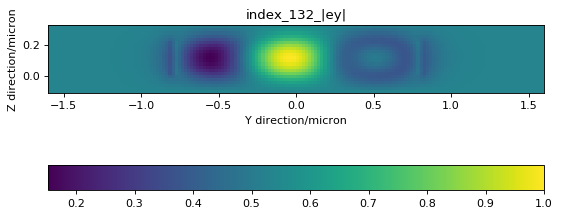

In [7]:
# view specified sample
index=132
plt.figure(num=None, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.title('index_{}_|ey|'.format(index))
plt.pcolormesh(yy,zz,np.abs(field_sp[0][index])/np.max(np.abs(field_sp[0][index])))
plt.xlabel("Y direction/micron")
plt.ylabel("Z direction/micron")
plt.ylim(-0.11, 0.33)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(orientation='horizontal')
plt.show()

In [8]:
# get farfield diffraction pattern
sp_y=y.shape[0] # sampling points along y
sp_z=z.shape[0] # sampling points along z
ff_data=[]
for i in range(m_all):
    ff_data.append(np.fft.fftshift(np.fft.fft2(field_sp[0][i]))/sp_y/sp_z)

In [9]:
ff_i_data=['' for i in range(m_all)]
for i in range(m_all):
    ff_i_data[i]=np.abs(ff_data[i])**2/np.max(np.abs(ff_data[i])**2)

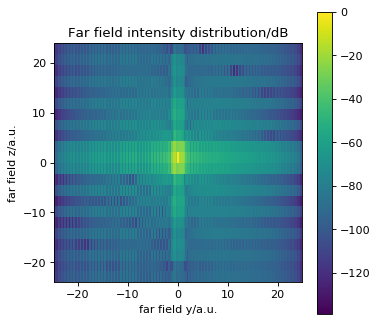

In [10]:
# view specified farfield pattern
sl_y=dy # sampling length(unit) along y
sl_z=dz # sampling length(unit) along z
sf_y=1/dy # sampling frequency along y
sf_z=1/dz # sampling frequency along z
f_y=np.fft.fftshift(np.fft.fftfreq(sp_y,sl_y))
f_z=np.fft.fftshift(np.fft.fftfreq(sp_z,sl_z))
index=132
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
plt.pcolormesh(f_y,f_z,10*np.log10(ff_i_data[index]))
plt.title('Far field intensity distribution/dB')
plt.xlabel('far field y/a.u.')
plt.ylabel('far field z/a.u.')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [11]:
ff_i_data[index].max()

1.0

In [12]:
ff_i_data_eff_index_0,ff_i_data_eff_index_1=np.nonzero(ff_i_data[np.random.randint(m_all)]>=1e-3)
print(ff_i_data_eff_index_0)
print(np.min(ff_i_data_eff_index_0),np.max(ff_i_data_eff_index_0))
print(ff_i_data_eff_index_1)
print(np.min(ff_i_data_eff_index_1),np.max(ff_i_data_eff_index_1))

[10 10 10 10 10 10 11 11 11 11 11 11 11 12 12 12 12 12 12]
10 12
[78 79 80 81 82 83 78 79 80 81 82 83 84 78 79 80 81 82 83]
78 84


In [13]:
ff_i_data_eff=['' for i in range(m_all)]
for i in range(m_all):
    ff_i_data_eff[i]=ff_i_data[i][9:12,70:91]

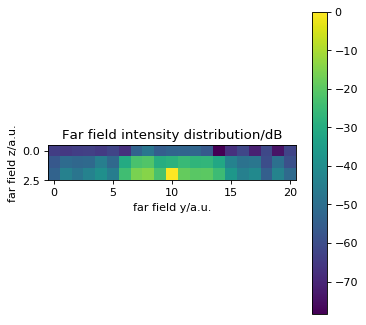

In [14]:
# view specified farfield pattern
sl_y=dy # sampling length(unit) along y
sl_z=dz # sampling length(unit) along z
sf_y=1/dy # sampling frequency along y
sf_z=1/dz # sampling frequency along z
f_y=np.fft.fftshift(np.fft.fftfreq(84-77,sl_y))
f_z=np.fft.fftshift(np.fft.fftfreq(13-10,sl_z))
index=132
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(10*np.log10(ff_i_data_eff[index]))
plt.title('Far field intensity distribution/dB')
plt.xlabel('far field y/a.u.')
plt.ylabel('far field z/a.u.')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [15]:
# converting 2D intensity to 1D features and shuffling
ff_i_data_eff=np.array(ff_i_data_eff)
ff_i_data_eff=ff_i_data_eff.reshape((300,-1)).T
permutation = list(np.random.permutation(m_all))
ff_i_data_eff_shuffled=ff_i_data_eff[:,permutation]
mode_comp_label_shuffled=mode_comp_label[:,permutation]

In [16]:
# converting to logarithmic data
X_train=-np.log10(ff_i_data_eff_shuffled[:,:200])
X_test=-np.log10(ff_i_data_eff_shuffled[:,200:300])
Y_train=mode_comp_label_shuffled[:,:200]
Y_test=mode_comp_label_shuffled[:,200:300]

In [17]:
# normalizing features
mu_x_train=np.mean(X_train,axis=1,keepdims=True)
var_x_train=np.var(X_train,axis=1,keepdims=True)+1e-12
X_train=(X_train-mu_x_train)/np.sqrt(var_x_train)
X_test=(X_test-mu_x_train)/np.sqrt(var_x_train)

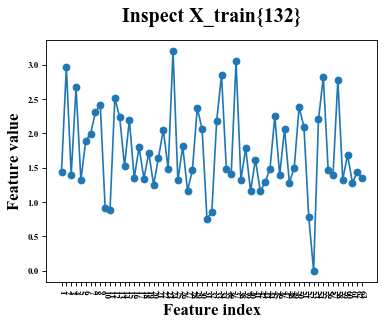

In [18]:
font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 8}

plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(X_train[:,index].shape[0]),X_train[:,index],'o-')
plt.title('Inspect X_train{{{}}}'.format(index), **font_suptitle,y=1.05)
plt.xlabel('Feature index', **font_label)
plt.ylabel('Feature value', **font_label)
plt.xticks(list(range(X_train[:,index].shape[0])),[str(i) for i in range(1,X_train[:,index].shape[0]+1)],
                                                                               **font_tick,rotation=-90)
plt.yticks(**font_tick)
plt.show()

In [19]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[n_y,None])
    return X, Y

In [20]:
def initialize_parameters(parameters=None):
    if parameters==None:
        tf.set_random_seed(2)   
        
        W1 = tf.get_variable("W1", [25,63], initializer = tf.contrib.layers.xavier_initializer(seed = 3))
        b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
        offset1 = tf.get_variable("offset1", [25,1], initializer = tf.zeros_initializer())
        scale1 = tf.get_variable("scale1",[25,1],initializer = tf.ones_initializer())
        
        W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 4))
        b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
        offset2 = tf.get_variable("offset2", [12,1], initializer = tf.zeros_initializer())
        scale2 = tf.get_variable("scale2",[12,1],initializer = tf.ones_initializer())
        
        W3 = tf.get_variable("W3", [3,12], initializer = tf.contrib.layers.xavier_initializer(seed = 5))
        b3 = tf.get_variable("b3", [3,1], initializer = tf.zeros_initializer())

    else:
        
        W1 = tf.get_variable("W1",  initializer = tf.constant(parameters['W1']))
        b1 = tf.get_variable("b1",  initializer = tf.constant(parameters['b1']))
        offset1 = tf.get_variable("offset1", initializer = tf.constant(parameters['offset1']))
        scale1 = tf.get_variable("scale1", initializer = tf.constant(parameters['scale1']))
        
        W2 = tf.get_variable("W2",  initializer = tf.constant(parameters['W2']))
        b2 = tf.get_variable("b2",  initializer = tf.constant(parameters['b2']))
        offset2 = tf.get_variable("offset2", initializer = tf.constant(parameters['offset2']))
        scale2 = tf.get_variable("scale2", initializer = tf.constant(parameters['scale2']))
        
        W3 = tf.get_variable("W3",  initializer = tf.constant(parameters['W3']))
        b3 = tf.get_variable("b3",  initializer = tf.constant(parameters['b3']))
    parameters = {"W1": W1,
                  "b1": b1,
                  "offset1": offset1,
                  "scale1": scale1,
                  "W2": W2,
                  "b2": b2,
                  "offset2": offset2,
                  "scale2": scale2,
                  "W3": W3,
                  "b3": b3,
                  }
    
    return parameters

In [21]:
def forward_propagation(X, parameters, pop_mean, pop_var, phase=True):   
    # Retrieve the parameters from the dictionary "parameters" 
    beta=tf.constant(0.9)
    W1 = parameters['W1']
    b1 = parameters['b1']
    offset1=parameters['offset1']
    scale1=parameters['scale1']
    pop_mean1=pop_mean['pop_mean1']
    pop_var1=pop_var['pop_var1']
    
    W2 = parameters['W2']
    b2 = parameters['b2']
    offset2=parameters['offset2']
    scale2=parameters['scale2']
    pop_mean2=pop_mean['pop_mean2']
    pop_var2=pop_var['pop_var2']
    
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1,X) + b1                                              # Z1 = np.dot(W1, X) + b1
    if phase:
        batch_mean1,batch_var1=tf.nn.moments(Z1, axes=1, keep_dims=True)
        pop_mean1=beta*pop_mean1+(1.-beta)*batch_mean1
        pop_var1=beta*pop_var1+(1.-beta)*batch_var1
    Z1 = tf.nn.batch_normalization(Z1,
                                   mean = mean1,
                                   variance = variance1,
                                   offset = offset1,
                                   scale = scale1,
                                   variance_epsilon=1e-12,
                                   name=None
                                  )
    A1 = tf.nn.tanh(Z1)                                              # A1 = tanh(Z1)
    Z2 = tf.matmul(W2,A1) + b2                                              # Z2 = np.dot(W2, a1) + b2
    if phase:
        temp_mean2,temp_variance2=tf.nn.moments(Z2, axes=1, keep_dims=True)
        mean2=beta*mean2+(1.-beta)*temp_mean2
        variance2=beta*variance2+(1.-beta)*temp_variance2
    Z2 = tf.nn.batch_normalization(Z2,
                                   mean = mean2,
                                   variance = variance2,
                                   offset = offset2,
                                   scale = scale2,
                                   variance_epsilon=1e-12,
                                   name=None
                                  )
    A2 = tf.nn.tanh(Z2)                                              # A2 = tanh(Z2)
    Z3 = tf.matmul(W3,A2) + b3                                              # Z3 = np.dot(W3,Z2) + b3
    mean = {"mean1": mean1,
            "mean2": mean2
           }
    variance = {"variance1": variance1,
                "variance2": variance2
               }
    return Z3,mean,variance

In [22]:
def compute_cost1(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    Z3 = tf.transpose(Z3)
    Y = tf.transpose(Y)
    A3 = tf.nn.softmax(Z3)
    cost = tf.reduce_mean(tf.reduce_sum(tf.abs(Y-A3),axis=1))
    
    return cost

In [23]:
def compute_cost2(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    Z3 = tf.transpose(Z3)
    Y = tf.transpose(Y)
    A3 = tf.nn.softmax(Z3)
    cost = tf.reduce_mean(tf.reduce_sum((Y-A3)**2,axis=1))
    
    return tf.transpose(A3),cost

In [24]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [31]:
def model(X_train, Y_train, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32, 
          parameters=None, lambd=0.01, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    seed = 6                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(parameters)
    
    # regularization
    if False: # True: implementing L2 regularization, False: do not implementing
        W1 = parameters["W1"]
        W2 = parameters["W2"]
        W3 = parameters["W3"]
        regularizer = tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)+tf.nn.l2_loss(W3)
    else:
        regularizer = tf.constant(0.)
        
    mean={"mean1": tf.get_variable(name='mean1',
                                shape=(25,1),
                                dtype=tf.float32,
                                initializer=tf.zeros_initializer(),
                                trainable=False,
                               ),
          "mean2": tf.get_variable(name='mean2',
                                shape=(12,1),
                                dtype=tf.float32,
                                initializer=tf.zeros_initializer(),
                                trainable=False,
                               )}
    variance={"variance1": tf.get_variable(name='variance1',
                                        shape=(25,1),
                                        dtype=tf.float32,
                                        initializer=tf.ones_initializer(),
                                        trainable=False,
                                       ),
              "variance2": tf.get_variable(name='variance2',
                                        shape=(12,1),
                                        dtype=tf.float32,
                                        initializer=tf.ones_initializer(),
                                        trainable=False,
                                       )}
     
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3,mean_inter,variance_inter = forward_propagation(X, parameters, mean, variance, phase=True)
    assign_mean = tf.assign(mean['mean1'],mean_inter['mean1'])
    assign_variance = tf.assign(variance['variance1'],variance_inter['variance1'])
    # Cost function: Add cost function to tensorflow graph
    # cost1 = compute_cost1(Z3, Y) # L1 norm
    _,cost2 = compute_cost2(Z3, Y) # L2 norm
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost2 + lambd * regularizer)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost2], feed_dict={X: minibatch_X, Y: minibatch_Y})
                sess.run([assign_mean,assign_variance])
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 10 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters,mean,variance = sess.run([parameters,mean,variance],feed_dict={X: X_train, Y: Y_train})
        print ("Parameters have been trained!")

        print ("Train mean square error:", sess.run(cost2,feed_dict={X: X_train, Y: Y_train}))
        
        return parameters, mean, variance

In [32]:
parameters, mean, variance=model(X_train, Y_train, learning_rate = 2e-4, num_epochs = 5000, minibatch_size = 16,
                                 parameters=None, lambd=5e-5, print_cost = True)
print(mean,variance)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [63,?]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[63,?], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder', defined at:
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-5d5c8a09575d>", line 2, in <module>
    parameters=None, lambd=5e-5, print_cost = True)
  File "<ipython-input-31-17eb68c426a1>", line 11, in model
    X, Y = create_placeholders(n_x, n_y)
  File "<ipython-input-19-d2eed9da5451>", line 2, in create_placeholders
    X = tf.placeholder(tf.float32,[n_x,None])
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Ang Liu\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [63,?]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[63,?], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
parameters, mean, variance=model(X_train, Y_train, learning_rate = 2e-4, num_epochs = 1, minibatch_size = 16,
                                 parameters=None, lambd=5e-5, print_cost = True)
print(mean,variance)

In [ ]:
def model_check(X_train, Y_train, X_test, Y_test, parameters = None, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(parameters)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    # cost1 = compute_cost1(Z3, Y) # L1 norm
    A3,cost2 = compute_cost2(Z3, Y) # L2 norm
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        [parameters, A3_train, cost2_train]=sess.run([parameters, A3, cost2], feed_dict={X: X_train, Y: Y_train})
        [A3_test,cost2_test]=sess.run([A3, cost2], feed_dict={X: X_test, Y: Y_test})
    if print_cost==True:
        print("Train mean square error: {:.2e}.".format(cost2_train))
        print("Test mean square error: {:.2e}.".format(cost2_test))
        
        
        return parameters,A3_train,cost2_train,A3_test,cost2_test

In [ ]:
f = open('parameters.data', 'rb')
parameters = pickle.load(f)
f.close()
parameters=model(X_train, Y_train, X_test, Y_test, learning_rate = 2e-4,
          num_epochs = 5000, minibatch_size = 8, parameters=parameters, lambd=5e-5, print_cost = True)

In [ ]:
parameters_set=[['' for i in range(10)] for j in range(10)]
np.random.seed(None)
lr_set=10**np.random.uniform(-4,-3,10)
lambd_set=10**np.random.uniform(-5,-3.5,10)
for i in range(len(lr_set)):
    for j in range(len(lambd)):
        f = open('parameters.data', 'rb')
        parameters = pickle.load(f)
        f.close()
        print('learning rate_{}: {}'.format(i,lr_set[i]))
        print('lambd_{}: {}'.format(j,lambd_set[j]))
        parameters_set[i][j]=model(X_train, Y_train, X_test, Y_test, learning_rate = lr_set[i],
          num_epochs = 5000, minibatch_size = 8, parameters=parameters, lambd=lambd_set[j], print_cost = True)

In [ ]:
f = open('parameters_L2_lambd_1eminus4.data', 'wb')
pickle.dump(parameters, f)
f.close()

In [ ]:
f = open('parameters.data', 'rb')
parameters = pickle.load(f)
f.close()

In [ ]:
[parameters,A3_train,cost_train,A3_test,cost_test]=model_check(X_train, Y_train, X_test, Y_test, parameters = parameters, print_cost = True)

In [ ]:
np.random.seed(None)
index=np.squeeze(np.random.randint(100,size=(1,1)))
print("index_{}:".format(index))
print(A3_test.T[index,:])
print(Y_test.T[index,:])

In [ ]:
A3_train=[['' for j in range(10)] for i in range(10)]
cost_train=np.zeros((10,10))
A3_test=[['' for j in range(10)] for i in range(10)]    
cost_test=np.zeros((10,10))
for i in range(len(lr_set)):
    for j in range(len(lambd)):
        [_,A3_train[i][j],cost_train[i,j],A3_test[i][j],cost_test[i,j]]=model_check(X_train, Y_train, X_test, Y_test, parameters = parameters_set[i][j], print_cost = True)

In [ ]:
min_tc_index=np.unravel_index(np.argmin(cost_test), (10,10)) # min test cost index
print(min_tc_index)

In [ ]:
cost_test[min_tc_index]

In [ ]:
cost_train[min_tc_index]

In [ ]:
# save hyprams minimizing cost_test
f = open('parameters_min_cost_test.data', 'wb')
pickle.dump([parameters_set[min_tc_index[0]][min_tc_index[1]],lr_set[min_tc_index[0]],lambd_set[min_tc_index[1]]], f)
f.close()

In [ ]:
f = open('parameters_min_cost_test.data', 'rb')
parameters_temp = pickle.load(f)
f.close()

In [ ]:
print(parameters_temp[1:])

In [ ]:
# save all the hyprams tuning set
f = open('hyprams_tuning.data', 'wb') # parameters_set, lr_set, lambd_set
pickle.dump([parameters_set,lr_set,lambd_set], f)
f.close()

In [ ]:
[parameters,A3_train,cost_train,A3_test,cost_test]=model_check(X_train, Y_train, X_test, Y_test, parameters = parameters_set[9][8], print_cost = True)